In [ ]:
%uv pip install numerapi pyarrow numerai-tools lightgbm -q

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [ ]:
import json
import warnings

import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from numerapi import NumerAPI
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
np.random.seed(42)

# Introduction


The goal of this notebbok is to better understand the variance spread as well as the correlation between features and target accross the dataset.



Lets remind the description of the starter set offered by Numerai:

- `small` contains a minimal subset of features (`42 features`) that have the highest [feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

- `medium` contains all the "basic" features (`740 features`), each unique in some way (e.g. P/E ratios vs analyst ratings)

- `all` contains all features in `medium` and their variants (`2562 features`) (e.g. P/E by country vs P/E by sector)


From the initial description from Numerai we expect `medium` to be the best tradeoff between exhaustivity and overfitting.


## Data Loading

Lets load the training data first:

In [ ]:
DATA_VERSION = "v5.1"
napi = NumerAPI()

napi.download_dataset(f"{DATA_VERSION}/features.json")
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
feature_sets = feature_metadata["feature_sets"]

# Load the list of features for each set
feature_set_small = feature_sets["small"]
feature_set_medium = feature_sets["medium"]
feature_set_all = feature_sets["all"]

# Download the training data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/train.parquet")
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era", "target"] + feature_set_all
)

# # Download validation data - this will take a few minutes
napi.download_dataset(f"{DATA_VERSION}/validation.parquet")
validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "target"] + feature_set_all
)


#Keep the last 100th eras for test set
validation_era = validation["era"].unique()[:-100]
validation = validation[validation["era"].isin(validation_era)]


The dataset is quite massive with more than 2K+ features and 2M+ rows.

In [2]:
print(f'Dataset size: {train.shape}')
print(f'Dataset memory usage: {train.memory_usage().sum() / 1024**2:.2f} MB')

Dataset size: (2746270, 2564)
Dataset memory usage: 6762.38 MB


## Variance Analysis

Lets start by checking how the variance is speard accross the dataset.

We do so by fitting a PCA and checking how much of the variance is explained by each feature set.

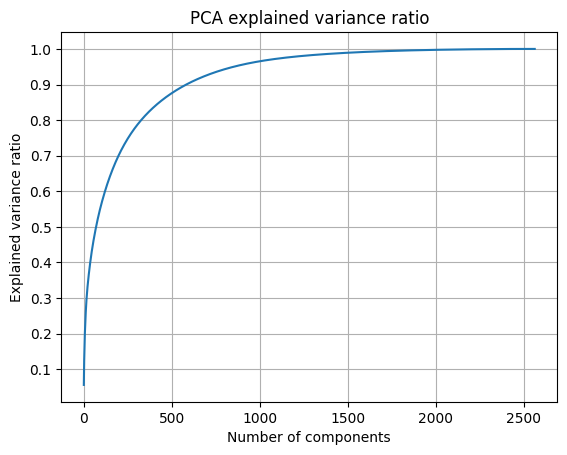

In [ ]:
# Randomly sample 5000 row indices for heavy computation
random_indices = np.random.choice(len(train), size=5000, replace=False)
train_reduced = train.iloc[random_indices]

pca = PCA()
pca.fit(train_reduced[feature_set_all])


# Plot the cumulative explained variance
plt.title("PCA explained variance ratio")
plt.xlabel("Number of components")
plt.ylabel("Explained variance ratio")
plt.plot(pca.explained_variance_ratio_.cumsum())

plt.gca().yaxis.set_major_locator(MultipleLocator(0.1)) 

plt.grid(True)
plt.show()

As we can see much of the variance is included in around 700 features. This is not surprising given `all` feature set is expected to be variant features from `medium`.

Actually the fact that between 250 and 750, the variance linearly increase show that we have a high quality dataset with a lot of information contained in.

In [ ]:
def compute_incremental_variance(feature_list, data):
    """
    Compute incremental variance for each feature using sequential regression.
    At step i, regress feature i on features 1..i-1, measure residual variance.
    
    Returns: array of incremental variances (one per feature)
    """
    n_features = len(feature_list)
    incremental_variances = np.zeros(n_features)
    
    # Process features sequentially
    for i in tqdm(range(n_features), desc="Processing features"):
        current_feature = feature_list[i]
        X_current = data[[current_feature]].values
        
        if i == 0:
            # First feature: just measure its variance
            incremental_variances[i] = np.var(X_current)
        else:
            # Regress current feature on all previous features
            prev_features = feature_list[:i]
            X_prev = data[prev_features].values
            
            reg = LinearRegression()
            reg.fit(X_prev, X_current)
            X_predicted = reg.predict(X_prev)
            
            # Residual variance = unique contribution of this feature
            residuals = X_current - X_predicted
            incremental_variances[i] = np.var(residuals)
    
    return incremental_variances

Processing features:   0%|          | 0/2593 [00:00<?, ?it/s]


Breakdown as % of total unique variance:
Small: 6.18%
Medium adds: 40.17%
All adds: 53.65%


In [ ]:
# # Randomly sample 3000 row indices for heavy computation
# random_indices = np.random.choice(len(train), size=4000, replace=False)
# train_reduced = train.iloc[random_indices]


# # Process features in order: small, then medium-only, then all-only
# all_features_ordered = (
#     feature_set_small +  # Process small features first
#     [f for f in feature_set_medium if f not in feature_set_small] +  # Then medium-only
#     [f for f in feature_set_all if f not in feature_set_medium]  # Then all-only
# )

# # Compute incremental variance for each feature
# incremental_variances = compute_incremental_variance(
#     all_features_ordered, 
#     train_reduced
# )

# # Find where each feature set ends
# n_small = len(feature_set_small)
# n_medium = len(feature_set_medium)
# n_all = len(feature_set_all)

# # Sum incremental variances for each feature set
# variance_small_unique = np.sum(incremental_variances[:n_small])
# variance_medium_unique = np.sum(incremental_variances[:n_medium])
# variance_all_unique = np.sum(incremental_variances[:n_all])

# # Additional contributions
# variance_medium_added = np.sum(incremental_variances[n_small:n_medium])
# variance_all_added = np.sum(incremental_variances[n_medium:n_all])


# print(f"\nBreakdown as % of total unique variance:")
# print(f"Small: {100*variance_small_unique/variance_all_unique:.2f}%")
# print(f"Medium adds: {100*variance_medium_added/variance_all_unique:.2f}%")
# print(f"All adds: {100*variance_all_added/variance_all_unique:.2f}%")

We observe that small is more dense in information than medium than all.
However each of these superset add a significant amount of information to the previous one.

## Predictive Power

Because feature variance and correlation with target may be unlinked, especially for a noisy target, we would like to check the predictive power of each set of features.

In [ ]:


def evaluate_predictive_power(eras_test, X_train, y_train, X_test, y_test, use_pca=False, n_components=None):

    # Fit PCA on training data only (if using PCA)
    if use_pca:
        pca = PCA(n_components=n_components)
        # We downsample for PCA training because PCA is expensive
        sample_idx = np.random.choice(X_train.shape[0], size=5000, replace=False)
        X_train_reduced = X_train.iloc[sample_idx]
        pca.fit(X_train_reduced)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
    

    model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    num_leaves=2**5-1,
    colsample_bytree=0.1,
    verbose=-1,
    seed=42
    )

    model.fit(X_train, y_train)
        

    # Predict on validation set and collect with eras
    y_pred_test = model.predict(X_test)
    val_df = pd.DataFrame({
        'y_true': y_test.values,
        'y_pred': y_pred_test,
        'era': eras_test.values
    })

    
    # Compute correlation per era for validation using groupby
    val_correlations_per_era = val_df.groupby('era').apply(
        lambda x: np.corrcoef(x['y_true'], x['y_pred'])[0, 1],
        include_groups=False
    )
    
    val_mean = val_correlations_per_era.mean()
    val_std = val_correlations_per_era.std()
    
    return {
        'val_mean': val_mean,
        'val_std': val_std,
    }

In [ ]:

eras_test, y_train, y_test = validation['era'], train['target'], validation['target']

# Compare feature sets
print("=" * 80)
print("Feature Set Comparison")
print("=" * 80)
for name, feature_set in [("small", feature_set_small), 
                          ("medium", feature_set_medium), 
                          ("all", feature_set_all)]:
    X_train = train[feature_set].values  # Convert to numpy array
    X_test = validation[feature_set].values
    results = evaluate_predictive_power(eras_test, X_train, y_train, X_test, y_test)
    print(f"\n{name.upper()}:")
    print(f"  Val correlation:     {results['val_mean']:.4f} ± {results['val_std']:.4f}")


# Compare PCA with different n_components
print("\n" + "=" * 80)
print("PCA Component Comparison")
print("=" * 80)
X_train = train[feature_set_all].values
X_test = validation[feature_set_all].values
for n_components in [50, 100, 200, 500]:
    results = evaluate_predictive_power(
        eras_test, X_train, y_train, X_test, y_test, use_pca=True, n_components=n_components
    )
    print(f"\nPCA({n_components}):")
    print(f"  Val correlation:     {results['val_mean']:.4f} ± {results['val_std']:.4f}")

- Despite containing most of the variances, PCA with reduced components are actually missing important target related information. We are not gonna use them for the rest of the study.

- `small` has a significant predictive power given its size hiwver its performances unmatch the ones from `medium`and `all`, therefore we are not gonna consider it any further.


- `medium` and `all` have similar performances. `medium` could be interresting to prevent overfitting, whereas `all` could be interresting to limit feature exposure. For now we are still gonna study both of them.


# Medium vs All

In this subsection, we'd like to confirm the hypothesis that `all` contains only variants of `medium`

Especially we'd like to quantify how much of the features from `all` are actually variants and how much are actually new features


To quantify this we compute for each feature from `all` only, its maximum correlation with one of the features from `medium`


In [ ]:
# Separate features: medium vs. all-only
features_only_in_all = [f for f in feature_set_all if f not in feature_set_medium]

# Compute max correlation for each feature in all-only
max_correlations = {}
train_reduced_medium = train_reduced[feature_set_medium]

for feat_all in features_only_in_all:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        corrs = train_reduced_medium.corrwith(
            train_reduced[feat_all]
        ).abs()
        corrs = corrs.fillna(0)
        max_correlations[feat_all] = corrs.max()

In [ ]:

# Visualize distribution

max_corr_values = list(max_correlations.values())

plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(max_corr_values, bins=50, edgecolor='black')
plt.axvline(x=0.9, color='r', linestyle='--', label='0.9')
plt.axvline(x=0.8, color='orange', linestyle='--', label='0.8')
plt.xlabel('Max correlation with medium features')
plt.ylabel('Frequency')
plt.title('Distribution of max correlations')
plt.legend()

# Cumulative distribution
plt.subplot(1, 2, 2)
sorted_corrs = np.sort(max_corr_values)[::-1]
plt.plot(sorted_corrs)
plt.axhline(y=0.9, color='r', linestyle='--', label='0.9')
plt.axhline(y=0.8, color='orange', linestyle='--', label='0.8')
plt.xlabel('Feature rank')
plt.ylabel('Max correlation')
plt.title('Cumulative max correlations')
plt.legend()

plt.tight_layout()
plt.show()

# 5. Summary statistics
print(f"Features only in 'all': {len(features_only_in_all)}")
print(f"Max correlation > 0.9: {(np.array(max_corr_values) > 0.9).sum()}")
print(f"Max correlation > 0.8: {(np.array(max_corr_values) > 0.8).sum()}")
print(f"Max correlation > 0.7: {(np.array(max_corr_values) > 0.7).sum()}")

The distribution of correlations can actually be split in 2 groups (under and over 0.8).

Therefore, `all` feature set does not contains only variants from `medium`but actually add some new features.

# Feature-To-Target Correlation


The key metrics we are interrested by are:
- Top features correlation with target
- Correlation stability across time

**NB**: Because features and target are binned, we should priorize spearman correlation over pearson correlation howver we are running with pearson here because this is significantly faster

### Features with no variance

Let's start by droping features with no variance, these are features that were not unable in the first eras. We may however keep them in the final model.

In [ ]:
feature_vars = train.drop(columns=["era", "target"]).var().sort_values()
feature_with_no_var = list(feature_vars[feature_vars == 0].index)

print(f'{len(feature_with_no_var)} features have zero variance')

train.drop(columns=feature_with_no_var, inplace=True)

### Per-era metrics

We compute the correlation with target by feature by era and look at:

- mean correlation over era
- std correlation over era
- sharp ratio


In [ ]:
# Per-era stability
era_corrs = []
for era in train['era'].unique():
    era_data = train[train['era'] == era]
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        corr = era_data.drop(columns=["era", "target"]).corrwith(era_data['target'], method='pearson')
    
    # Set NaN (from zero variance) to 0
    corr = corr.fillna(0)
    
    era_corrs.append(corr)

corr_stability_df = pd.DataFrame(era_corrs)
feature_std_corr= corr_stability_df.std(axis=0)
feature_mean_corr = corr_stability_df.mean(axis=0).abs()
feature_sharp_corr = feature_mean_corr / feature_std_corr

In [ ]:
feature_sharp_corr.sort_values(ascending=False).plot(kind='bar', xticks=[], title="Correlation with target ratio sharpe over eras")

In [ ]:
feature_mean_corr.sort_values(ascending=False).plot(kind='bar', xticks=[], title="Correlation with target ratio mean over eras")

In [ ]:
feature_std_corr.sort_values(ascending=False).plot(kind='bar', xticks=[], title="Correlation with target ratio std over eras")

### Incertitude measure

Actually we need to check the relevance of these results.

Because there is only around 5000 datapoint for each era, this mean the correlation estimation for an era have a magnitude order incertitude of around 1 / sqrt(5000) = 0.014


The correlation std observed through era is of same magnitude order. This means incertitude itself is enough to explain std. We need to augment the number of datapoint for each correlation measure to effectively measure the standard deviation of correlation accros time.


We will split the dataset in 20 parts only. This give us more than 100k datapoint by part and so an incertitude magnitude order of 1 / sqrt(10^6) = 0.001

In [ ]:
n_splits = 15

# Split dataset into n_splits parts
n_samples = len(train)
samples_per_split = n_samples // n_splits

# Store correlations for each split
split_corrs = []

for i in range(n_splits):
    start_idx = i * samples_per_split
    end_idx = (i + 1) * samples_per_split if i < n_splits - 1 else n_samples
    
    split_data = train.iloc[start_idx:end_idx]
    
    # Compute correlation for this split
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        corr = split_data.drop(columns=["era", "target"]).corrwith(
            split_data['target'], method='pearson'
        )
    
    # Set NaN (from zero variance) to 0
    corr = corr.fillna(0)
    
    split_corrs.append(corr)

# Convert to DataFrame (rows = splits, columns = features)
split_corr_df = pd.DataFrame(split_corrs)

# Compute statistics across splits
feature_mean_corr_split = split_corr_df.mean(axis=0).abs()  # Mean correlation per feature
feature_std_corr_split = split_corr_df.std(axis=0)  # Std across splits
feature_sharp_corr_split = feature_mean_corr_split / feature_std_corr_split  # Sharpe ratio

# Uncertainty measure: 1/sqrt(samples_per_split)
uncertainty_measure = 1 / np.sqrt(samples_per_split)
print(f"Number of splits: {n_splits}")
print(f"Samples per split: {samples_per_split}")
print(f"Uncertainty measure per split: {uncertainty_measure:.6f}")

In [ ]:
feature_sharp_corr_split.sort_values(ascending=False).plot(kind='bar', xticks=[], title="Correlation with target ratio sharpe over eras")

In [ ]:
feature_std_corr_split.sort_values(ascending=False).plot(kind='bar', xticks=[], title="Correlation with target ratio std over eras")

We do confirm that a few features have a sharp ratio over 1 which allow to have raxw signal for prediction.

However the main observation is that most of the features ahave a sharp ratio bellow 1 which means they are unstable and may harm the performance model.